# 8 Puzzle Solver using IDA*
Use IDA* to solve classic 8 Puzzle:

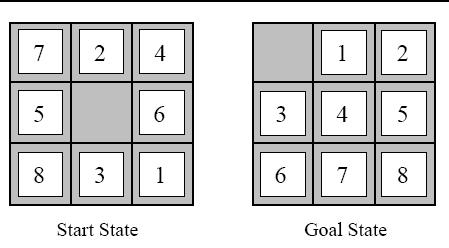
### Authors: Emilio González, Santiago Reyes, Cristian Cázares y Marisol Rodriguez
## Warning: Some puzzles take several minutes to be solved

## PUZZLE TO BE SOLVED

In [1]:
puzzle = [[4,1,3],
          [7,0,5],
          [8,2,6]]
''' Hard puzzle! Takes several minutes to be solved
puzzle = [[7,2,4],
          [5,0,6],
          [8,3,1]]
'''

' Hard puzzle! Takes several minutes to be solved\npuzzle = [[7,2,4],\n          [5,0,6],\n          [8,3,1]]\n'

In [2]:
from copy import deepcopy
from time import sleep
from os import system, name
from IPython.display import clear_output

def clear():
    # windows
    if name == 'nt':
        _ = system('cls')

    # mac and linux(here, os.name is 'posix')
    else:
        _ = system('clear')

## Puzzle utilities

In [3]:
'''
resDict works as the final puzzle:
    1 2 3
    4 5 6
    7 8 0
'''
resDict={
    0:(2,2),
    1:(0,0),
    2:(0,1),
    3:(0,2),
    4:(1,0),
    5:(1,1),
    6:(1,2),
    7:(2,0),
    8:(2,1)
}

def printPuzzle(p):
    for line in p:
        for num in line:
            if num == 0:
                print("█", end=" ")
            else:
                print(num, end=" ")
        print()

# For input as text files (Optional)
def readPuzzle(fileName: str):
    file = open(fileName, 'r+')
    lines = file.readlines()
    m = []
    for line in lines:
        intLine = []
        for c in line[:-1]:
            intLine.append(int(c))
        m.append(intLine)
    return m

## Calculate H
IDA* uses an heuristic to determinate how close a current state is to the correct solution

We use the Manhatthan Distance to know how far a number is from its target position and added said distance across all the cells to determinate a H value. 

In [4]:
def calcH(mat):
    h=0
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            at=mat[i][j]
            iDif=abs(i-resDict[at][0])
            jDif=abs(j-resDict[at][1])
            h+=(iDif+jDif)
    return h

## Generate States
Receives a puzzle and looks for the empty cell (value of 0). Then according, to its position, it generates a list of new matrices with every move that can take the place of the empty cell.

It also calculates the H value for each generated matrix and returns both H and matrix as a tuple.

In [5]:
def generateStates(mat):
    myI=0
    myJ=0
    encontrado=False
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                myI=i
                myJ=j
                encontrado=True
                break
        if encontrado:
            break
    #Ya encontramos el 0
    
    #Determinar posibles numeros a mover a la posición del 0
    #Este proceso resulta en un arreglo de estados posibles del puzzle
    stateArr=[]
    if myI<len(mat)-1:
        #down
        newMat=deepcopy(mat)
        #Hacemos swap
        newMat[myI][myJ]=newMat[myI+1][myJ]
        newMat[myI+1][myJ]=0
        stateArr.append((newMat, calcH(newMat)))
    if myI>0:
        #up
        newMat=deepcopy(mat)
        #Hacemos swap
        newMat[myI][myJ]=newMat[myI-1][myJ]
        newMat[myI-1][myJ]=0
        stateArr.append((newMat, calcH(newMat)))
    if myJ<len(mat[0])-1:
        #left
        newMat=deepcopy(mat)
        #Hacemos swap
        newMat[myI][myJ]=newMat[myI][myJ+1]
        newMat[myI][myJ+1]=0
        stateArr.append((newMat, calcH(newMat)))
    if myJ>0:
        #right
        newMat=deepcopy(mat)
        #Hacemos swap
        newMat[myI][myJ]=newMat[myI][myJ-1]
        newMat[myI][myJ-1]=0
        stateArr.append((newMat, calcH(newMat)))
    return stateArr

## Tree node
A class that works as a node in order to create a tree of all the generated states.
It stores:
* The father node
* The matrix of the node itself
* Its H value
* Its G value

#### G Value
The G Value is the depth of a node, it is used to pick between multiple nodes with the same H value in order to pick the solution that was found first (the iterative deepening search part of IDA*).

In [6]:
class treeNode():
  def __init__(self, fatherState, myState, hVal, gVal):
    self.father=fatherState
    self.state=myState
    self.h=hVal
    self.g=gVal
    self.children=[] #Vamos a guardar mas treeNodes
  def getValues(self):
    return {"h":self.h, "g": self.g}
  def getChildren(self):
    return self.children
  def getState(self):
    return self.state
  def addChildren(self, newChildren):
    for c in newChildren:
      self.children.append(c)
  def getChildren(self):
    return self.children
  def getParent(self):
    return self.father
  def print(self):
    print('--------------------------')
    print(f"h: {self.h}, g: {self.g}")
    printPuzzle(self.state)

## Find a suitable solution
Takes the original puzzle and iteratively starts generating childrens. Chooses to generate children to the ones that had a lesser H value.

Once the first child with H value of zero is found, we found a minimal optimal solution. Then it keeps generating children to the sibling nodes in order to find one that has an H value of zero with a lesser G. If not found, it only expands all off the siblings until the G value (the depth) of each is equals to the G value of the minimal optimal solution.

In [7]:
firstNode=treeNode(None,puzzle,calcH(puzzle),0)

stateQueue=[(firstNode, [firstNode.getState()])]
stateStack=[]
def iterativeMakeChildren(node, maxDepth=float('inf'), visited=[]):
  
  visited.append(node.getState())
  currentValues=node.getValues()
  if currentValues['h']==0:

    return (node,node) #Este es nuestro camino optimo
  if currentValues['g']>maxDepth:
    return (node,None)
                   
  newStates=generateStates(node.getState())
  newNodes=[]
  minH=float('inf')
  for i in newStates:      
    newNode=treeNode(node, i[0], i[1], node.getValues()["g"]+1)
    newNodes.append(newNode)
    #visited.append(i)
    if i[1]<minH and i[0] not in visited:
      minH=i[1]
  optimalNode=None
  for n in newNodes:
    
    #bucle de empates
    if n.getValues()['h']==minH : 
      stateQueue.append((n, visited))
    elif n.getState() not in visited:
      stateStack.append((n, visited))

  node.addChildren(newNodes)
  return (node, optimalNode, visited)

## Track the path to get to the found solution
Once the optimal solution is found, in order to visualize the path to get to it, we go to each of the parents of the final node.

In [8]:
path = []
def findSolution():
    print("Found solutions:")
    global path
    maxD=float('inf')
    optimalNode=None
    while stateQueue or stateStack:
        currentN=()
        if stateQueue:
            currentN=stateQueue.pop(0)
        else:
            currentN=stateStack.pop(-1)
        functionCall=iterativeMakeChildren(currentN[0], visited=currentN[1], maxDepth=maxD)
        resOptimalNode=functionCall[1]
        if resOptimalNode and resOptimalNode.getValues()['g']<maxD:
            optimalNode=resOptimalNode
            optimalNode.print()
            maxD = optimalNode.getValues()['g']
            print(maxD)
    print("Best found solution:")
    optimalNode.print()
    #Encontrar el path
    node=optimalNode
    while node:
        path.append(node.getState())
        node=node.getParent()
        
    path=path[::-1]
findSolution()


Found solutions:
--------------------------
h: 0, g: 8
1 2 3 
4 5 6 
7 8 █ 
8
Best found solution:
--------------------------
h: 0, g: 8
1 2 3 
4 5 6 
7 8 █ 


# Visualization

In [22]:
for x, mat in enumerate(path):
    print(f"----------Original-----------")
    printPuzzle(path[0])
    if (x == len(path) - 1):
        print(f"----Step {x}. SOLVED!-----")
        printPuzzle(mat)
        sleep(0.4)
        break
    print(f"---------Step {x}---------")
    printPuzzle(mat)
    sleep(0.4)
    clear()
    clear_output(wait=True)

print("Re run this block of code to repeat")

----------Original-----------
4 1 3 
7 █ 5 
8 2 6 
----Step 8. SOLVED!-----
1 2 3 
4 5 6 
7 8 █ 
Re run this block of code to repeat
